In [4]:
import numpy as np

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute, transpile
from qiskit.providers.aer import QasmSimulator
from qiskit.visualization import plot_histogram, plot_state_city, plot_gate_map
import qiskit_aer.noise as noise

In [5]:
class ClassicalOracle:
    def __init__(self, secret: np.array):
        self.n = len(secret)
        self.count = 0
        self.secret = secret

    def complexity(self) -> int:
        return self.n

    def number_of_queries(self) -> int:
        return self.count

    def query(self, inp: np.array) -> bool:
        self.count += 1
        product = np.dot(self.secret, inp)
        return product % 2


def classical_bv_algorithm(oracle: ClassicalOracle) -> np.array:
    n = oracle.complexity()
    secret = np.zeros(n, dtype=np.byte)

    for i in range(n):
        inp = np.zeros(n, dtype=np.byte)
        inp[i] = 1

        if oracle.query(inp):
            secret[i] = 1

    return secret

In [6]:
secret_str = list("0010")

secret = np.array(secret_str, dtype=np.byte)
oracle = ClassicalOracle(secret)

solution = classical_bv_algorithm(oracle)

print("secret string:".ljust(20, " "), secret)
print("classical solution:".ljust(20, " "), solution)
print("match:".ljust(20, " "), np.array_equal(solution, secret))
print("# of queries:".ljust(20, " "), oracle.number_of_queries())

secret string:       [0 0 1 0]
classical solution:  [0 0 1 0]
match:               True
# of queries:        4


In [7]:
n = len(secret)

query_reg = QuantumRegister(n, "query")
auxiliary_reg = QuantumRegister(1, "auxiliary")
oracle = QuantumCircuit(query_reg, auxiliary_reg, name="oracle")

for i in range(n):
    if secret[n - i - 1]:
        oracle.cx(query_reg[i], auxiliary_reg[0])

oracle.draw()

query_0: ─────
                
  query_1: ──■──
             │  
  query_2: ──┼──
             │  
  query_3: ──┼──
           ┌─┴─┐
auxiliary: ┤ X ├
           └───┘

In [8]:
qr = QuantumRegister(n, "q")
cr = ClassicalRegister(n, "c")
aux = QuantumRegister(1, "aux")
qc = QuantumCircuit(qr, aux, cr)

qc.h(qr)
qc.x(aux)
qc.h(aux)

qc.append(oracle, [*qr, aux])

qc.h(qr)
qc.barrier()

qc.measure(qr, cr)

qc.draw()

┌───┐     ┌─────────┐┌───┐ ░ ┌─┐         
q_0: ┤ H ├─────┤0        ├┤ H ├─░─┤M├─────────
     ├───┤     │         │├───┤ ░ └╥┘┌─┐      
q_1: ┤ H ├─────┤1        ├┤ H ├─░──╫─┤M├──────
     ├───┤     │         │├───┤ ░  ║ └╥┘┌─┐   
q_2: ┤ H ├─────┤2 oracle ├┤ H ├─░──╫──╫─┤M├───
     ├───┤     │         │├───┤ ░  ║  ║ └╥┘┌─┐
q_3: ┤ H ├─────┤3        ├┤ H ├─░──╫──╫──╫─┤M├
     ├───┤┌───┐│         │└───┘ ░  ║  ║  ║ └╥┘
aux: ┤ X ├┤ H ├┤4        ├──────░──╫──╫──╫──╫─
     └───┘└───┘└─────────┘      ░  ║  ║  ║  ║ 
c: 4/══════════════════════════════╩══╩══╩══╩═
                                   0  1  2  3

In [9]:
job = execute(qc, Aer.get_backend("qasm_simulator"), shots=1000)
counts = job.result().get_counts()

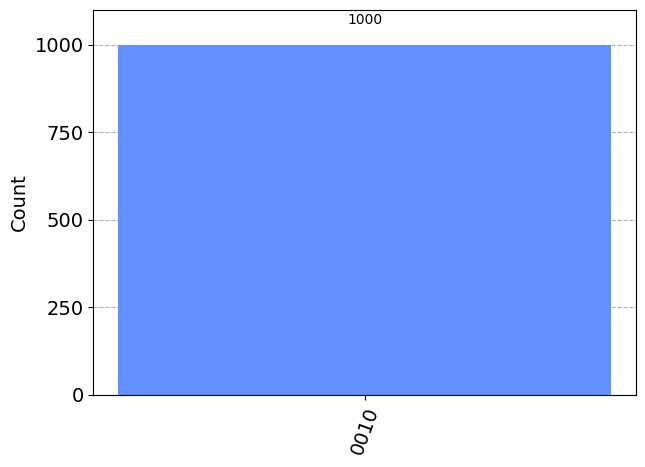

In [10]:
plot_histogram(counts)

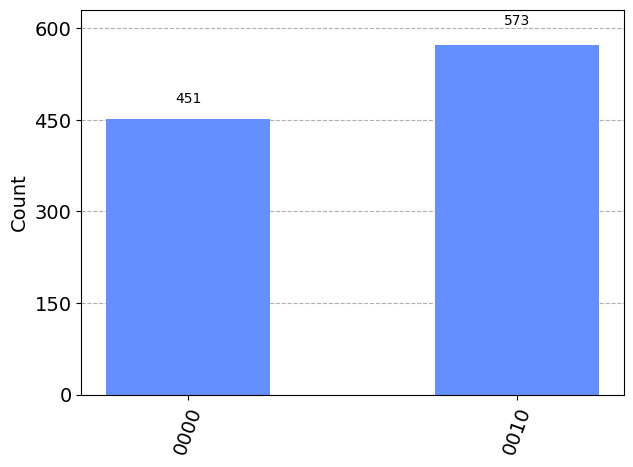

In [11]:
# Error probabilities
prob_1 = 0.3  # 1-qubit gate
prob_2 = 0.3  # 2-qubit gate

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)

# Add errors to noise model
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ["h", "z", "x"])
noise_model.add_all_qubit_quantum_error(error_2, ["cx"])

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

# transpiled_qc = transpile(qc, qasm_simulator)
# Execute circuit and show results
ex = execute(
    qc,
    Aer.get_backend("qasm_simulator"),
    basis_gates=basis_gates,
    noise_model=noise_model,
)
counts = ex.result().get_counts(qc)

plot_histogram(counts)

In [12]:
d1 = dict(list(counts.items()))
d2 = {"".join(secret_str) : counts["".join(secret_str)]}

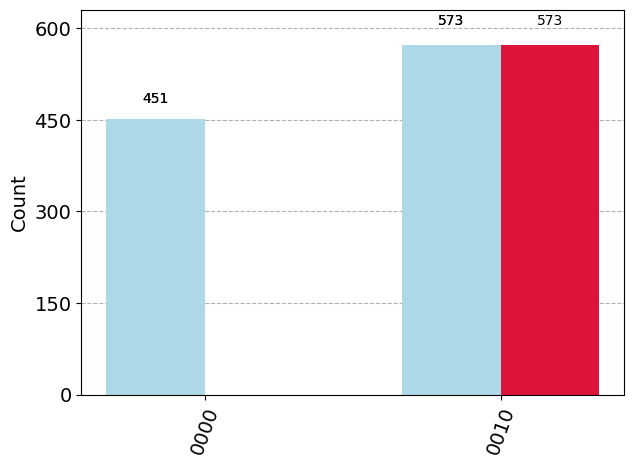

In [13]:
plot_histogram([d1, d2], color=['lightblue','crimson'])

In [14]:
simulator = QasmSimulator()
compiled_circuit = transpile(qc, simulator)
job = simulator.run(compiled_circuit, shots=1000)
result = job.result()
counts = result.get_counts(qc)
print("\nTotal count for 00 and 11 are:",counts)


Total count for 00 and 11 are: {'0010': 1000}


In [15]:
# !pip install qiskit-ibm-runtime

# from qiskit_ibm_runtime import QiskitRuntimeService

# QiskitRuntimeService.save_account(channel="ibm_quantum", token="...")
# service = QiskitRuntimeService()

In [18]:
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy

# service = IBMQ.enable_account("")
print(service.backends())
backend = least_busy(service.backends(filters=lambda x: x.configuration().n_qubits >= (n+1) and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_jakarta') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibm_lagos') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibm_nairobi') from I

In [20]:
transpiled_bv_circuit = transpile(qc, backend)

In [23]:


shots = 1024
job = backend.run(transpiled_bv_circuit, shots=shots)

from qiskit.tools.monitor import job_monitor
job_monitor(job, interval=2)

Job Status: job has successfully run


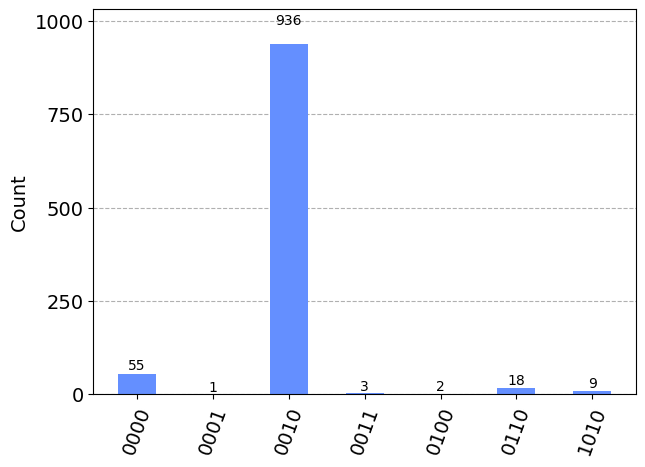

In [24]:
results = job.result()
answer = results.get_counts()

plot_histogram(answer)

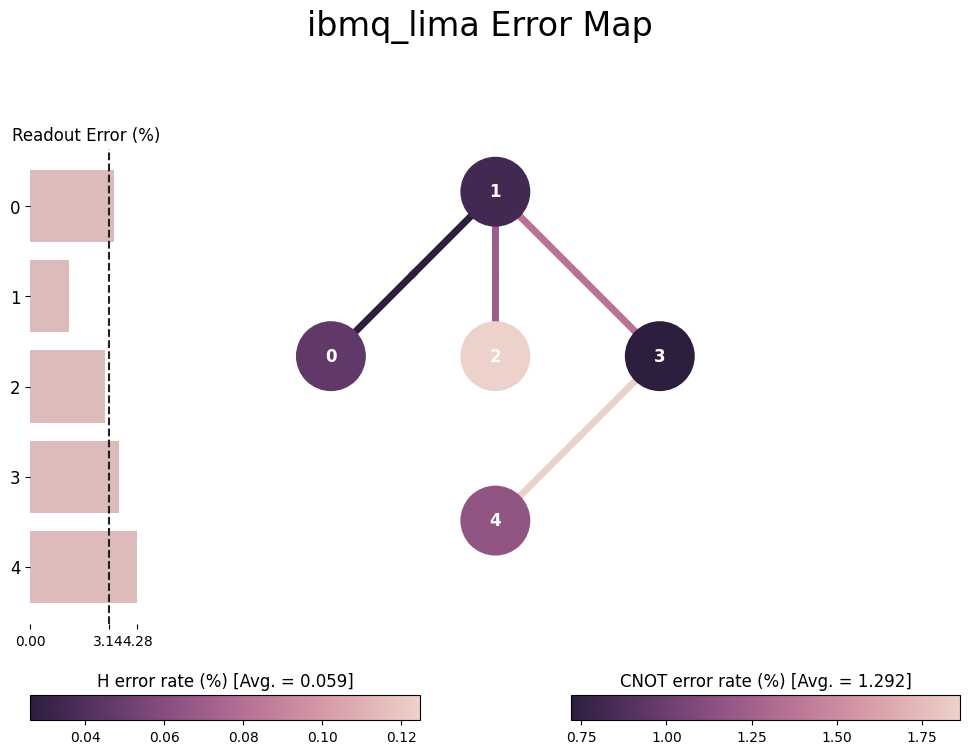

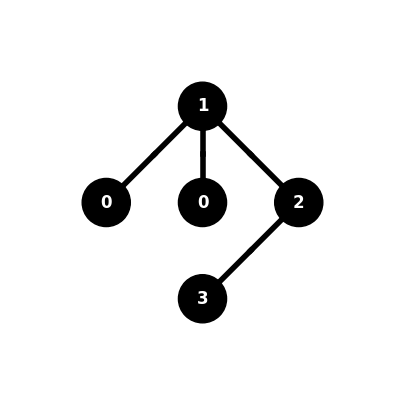

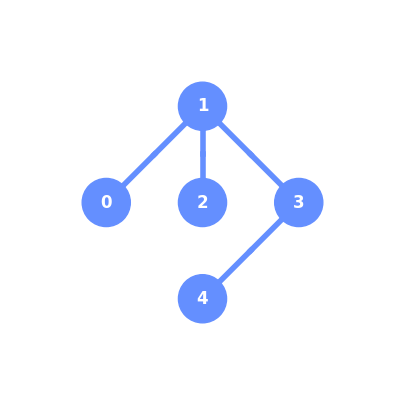

In [22]:
from qiskit.visualization import plot_error_map, plot_circuit_layout, plot_gate_map

display(plot_error_map(backend))
display(plot_circuit_layout(transpiled_bv_circuit, backend))
display(plot_gate_map(backend))